In [1]:
%pip install ace_tools_open

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools_open as tools
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
file_paths = {
    "no": "/home/maxim/git/net-arch-research/experiments/total_perceptron_tests/aggregations/0_final_analysis_results_no.json",
    "sure": "/home/maxim/git/net-arch-research/experiments/total_perceptron_tests/aggregations/0_final_analysis_results_sure.json",
    "huge": "/home/maxim/git/net-arch-research/experiments/total_perceptron_tests/aggregations/0_final_analysis_results_huge.json",
}

results_folder = "./handle_results/"

# check if all files exist
for key, path in file_paths.items():
    try:
        with open(path, 'r') as f:
            data = json.load(f)
            print(f"Loaded {key} data successfully.")
    except FileNotFoundError:
        print(f"File not found: {path}")
        exit(1)

Loaded no data successfully.
Loaded sure data successfully.
Loaded huge data successfully.


In [4]:
data = {}
for arch, path in file_paths.items():
    with open(path, "r", encoding="utf-8") as f:
        data[arch] = json.load(f)

In [5]:
# Соберем таблицу со средними значениями по каждому признаку и архитектуре
results = defaultdict(list)

for arch in data:
    cca_x = data[arch]["aggregated_cca"]["aggregated_x_weights"]["by_shape"]
    for shape, stats in cca_x.items():
        mean_vectors = stats["mean"]
        for i, vec in enumerate(mean_vectors):
            mean_val = sum(vec) / len(vec)  # усреднение по компонентам
            results["architecture"].append(arch)
            results["shape"].append(shape)
            results["feature_index"].append(i)
            results["mean_weight"].append(mean_val)

# Преобразуем в DataFrame
cca_x_all_shapes_df = pd.DataFrame(results)

# Сгруппируем и пересчитаем pivot-таблицу
pivot_df = cca_x_all_shapes_df.pivot_table(
    index=["shape", "feature_index"], columns="architecture", values="mean_weight"
)
pivot_df["huge - no"] = pivot_df["huge"] - pivot_df["no"]
pivot_df["huge - sure"] = pivot_df["huge"] - pivot_df["sure"]
pivot_df["sure - no"] = pivot_df["sure"] - pivot_df["no"]

tools.display_dataframe_to_user(name="Aggregated CCA X Weights by Shape", dataframe=pivot_df)

Aggregated CCA X Weights by Shape


Loading ITables v2.4.0 from the internet... (need help?)


In [6]:
# Обобщим анализ CCA Y-весов для всех доступных форм из aggregated_y_weights.by_shape
results_y = defaultdict(list)

for arch in data:
    cca_y = data[arch]["aggregated_cca"]["aggregated_y_weights"]["by_shape"]
    for shape, stats in cca_y.items():
        mean_vectors = stats["mean"]
        for i, vec in enumerate(mean_vectors):
            mean_val = sum(vec) / len(vec)  # усреднение по компонентам
            results_y["architecture"].append(arch)
            results_y["shape"].append(shape)
            results_y["feature_index"].append(i)
            results_y["mean_weight"].append(mean_val)

# Преобразуем в DataFrame
cca_y_all_shapes_df = pd.DataFrame(results_y)

# Сгруппируем и пересчитаем pivot-таблицу
pivot_y_df = cca_y_all_shapes_df.pivot_table(
    index=["shape", "feature_index"], columns="architecture", values="mean_weight"
)
pivot_y_df["huge - no"] = pivot_y_df["huge"] - pivot_y_df["no"]
pivot_y_df["huge - sure"] = pivot_y_df["huge"] - pivot_y_df["sure"]
pivot_y_df["sure - no"] = pivot_y_df["sure"] - pivot_y_df["no"]

tools.display_dataframe_to_user(name="Aggregated CCA Y Weights by Shape", dataframe=pivot_y_df)

Aggregated CCA Y Weights by Shape


Loading ITables v2.4.0 from the internet... (need help?)


In [7]:
def collect_aggregates(arch_name, arch_json):
    result = []
    for key, val in arch_json.items():
        if key in ["aggregated_cca", "feature_importance", "total_samples", "shapes_distribution"]:
            continue
        if "aggregated" in val:
            for stat_type, stat_vals in val["aggregated"].items():
                result.append(
                    {
                        "architecture": arch_name,
                        "parameter": key,
                        "statistic": stat_type,
                        "mean": stat_vals.get("mean"),
                        "std": stat_vals.get("std"),
                        "min": stat_vals.get("min"),
                        "max": stat_vals.get("max"),
                    }
                )
    return result

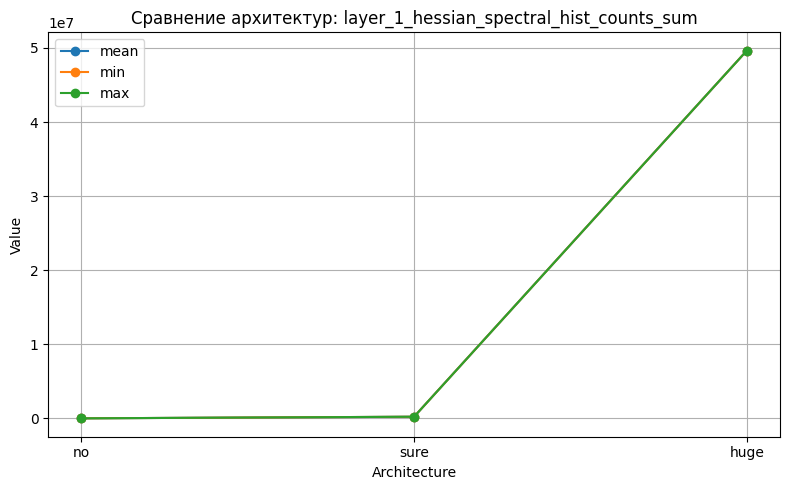

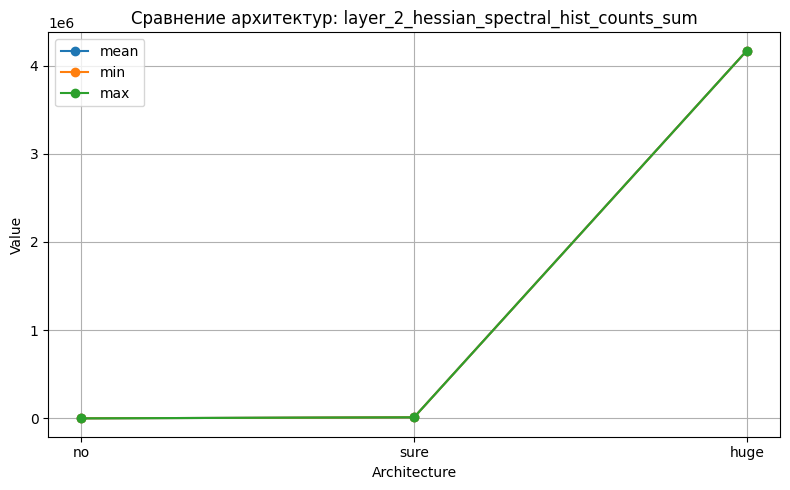

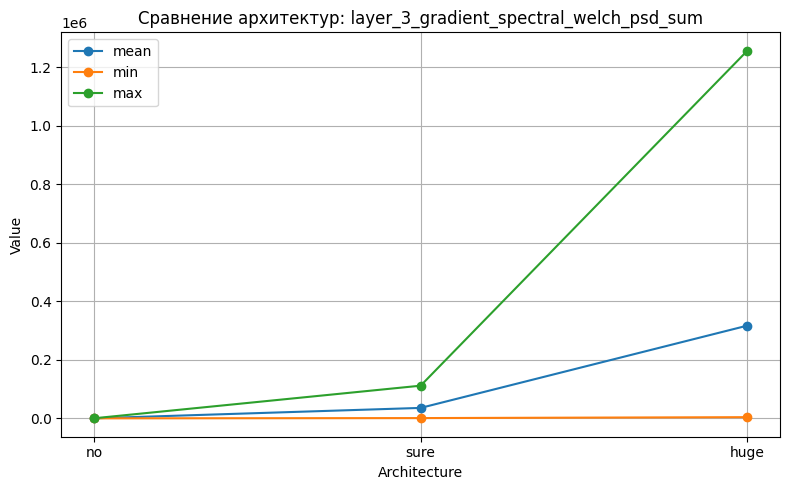

In [8]:
aggregate_stats = []
for arch, data_content in data.items():
    aggregate_stats.extend(collect_aggregates(arch, data_content))

aggregated_df = pd.DataFrame(aggregate_stats)

aggregated_cleaned = aggregated_df.dropna(subset=["mean"])

pivot_df = aggregated_cleaned.pivot_table(
    index=["parameter", "statistic"], columns="architecture", values="mean"
)

# Вычислим разности между архитектурами
pivot_df["huge - no"] = pivot_df["huge"] - pivot_df["no"]
pivot_df["huge - sure"] = pivot_df["huge"] - pivot_df["sure"]
pivot_df["sure - no"] = pivot_df["sure"] - pivot_df["no"]

# Посмотрим на признаки с наибольшими различиями
pivot_df["abs_diff_max"] = pivot_df[["huge - no", "huge - sure", "sure - no"]].abs().max(axis=1)

# Отберем топ-10 наиболее различающихся признаков
top_diff_df = pivot_df.sort_values("abs_diff_max", ascending=False).head(10)

# Выберем топ-3 параметра с максимальной разницей
top_3_params = top_diff_df.reset_index()["parameter"].unique()[:3]

# Фильтруем оригинальный DataFrame
plot_df = aggregated_cleaned[aggregated_cleaned["parameter"].isin(top_3_params)]

# Построим графики
for param in top_3_params:
    sub_df = plot_df[plot_df["parameter"] == param]
    plt.figure(figsize=(8, 5))
    for stat in ["mean", "min", "max"]:
        stat_df = sub_df[sub_df["statistic"] == stat]
        plt.plot(stat_df["architecture"], stat_df["mean"], marker="o", label=stat)
    plt.title(f"Сравнение архитектур: {param}")
    plt.ylabel("Value")
    plt.xlabel("Architecture")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{results_folder}{param}_comparison.pdf")
    plt.show()

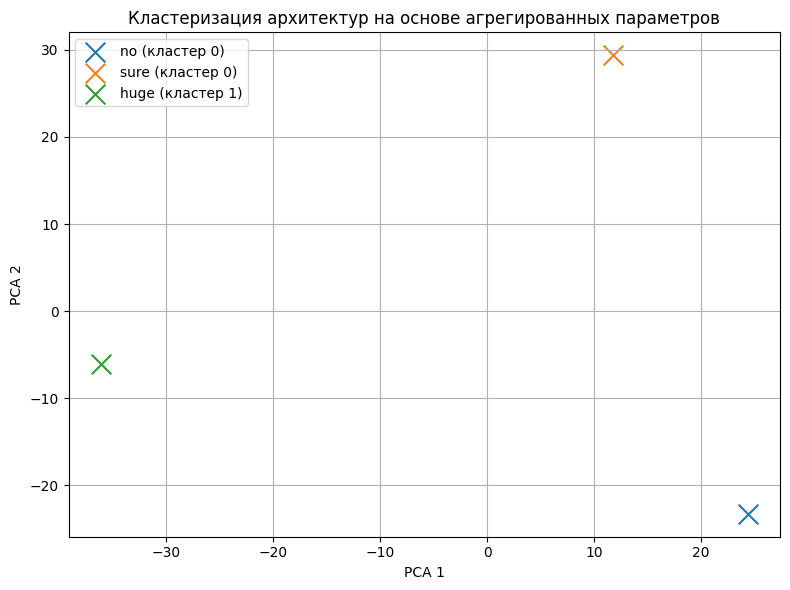

In [9]:
# Подготовим данные: pivot без строк с NaN
cluster_base = pivot_df[["no", "sure", "huge"]].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_base.T)  # транспонируем: строки — архитектуры

# PCA до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Кластеризация
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# Визуализация
plt.figure(figsize=(8, 6))
for i, arch in enumerate(cluster_base.columns):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], label=f"{arch} (кластер {labels[i]})", s=200, marker="x")
plt.title("Кластеризация архитектур на основе агрегированных параметров")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{results_folder}architecture_clustering.pdf")
plt.show()

In [10]:
# Отберем параметры, связанные с весами (weights), исключая bias
weight_df = aggregated_cleaned[
    aggregated_cleaned["parameter"].str.contains("weights")
    & ~aggregated_cleaned["parameter"].str.contains("bias", case=False)
]

# Удалим строки с пропущенными значениями
weight_df = weight_df.dropna(subset=["mean"])

# Сгруппируем по параметрам и статистике
pivot_weights = weight_df.pivot_table(
    index=["parameter", "statistic"], columns="architecture", values="mean"
)

# Вычислим разницы
pivot_weights["huge - no"] = pivot_weights["huge"] - pivot_weights["no"]
pivot_weights["huge - sure"] = pivot_weights["huge"] - pivot_weights["sure"]
pivot_weights["sure - no"] = pivot_weights["sure"] - pivot_weights["no"]
pivot_weights["abs_diff_max"] = (
    pivot_weights[["huge - no", "huge - sure", "sure - no"]].abs().max(axis=1)
)

# Отберем топ-10 различающихся весовых признаков
top_weight_diff_df = pivot_weights.sort_values("abs_diff_max", ascending=False).head(10)

tools.display_dataframe_to_user(
    name="Top Differentiating Weight Parameters", dataframe=top_weight_diff_df
)

Top Differentiating Weight Parameters


Loading ITables v2.4.0 from the internet... (need help?)


In [11]:
def extract_statistics(arch_data, arch_name):
    results = []
    for weight_type in ["aggregated_x_weights", "aggregated_y_weights"]:
        for shape, stats in arch_data["aggregated_cca"][weight_type]["by_shape"].items():
            entry = {
                "Architecture": arch_name,
                "Weight Type": weight_type,
                "Shape": shape,
                "Mean Var (dim 0)": sum(stats["var"][0]) / len(stats["var"][0]),
                "Mean Var (dim 1)": sum(stats["var"][1]) / len(stats["var"][1]),
                "Std Dev (dim 0)": sum(stats["std"][0]) / len(stats["std"][0]),
                "Std Dev (dim 1)": sum(stats["std"][1]) / len(stats["std"][1]),
            }
            results.append(entry)
    return results


# Compile all architectures
all_stats = []
for arch_name, arch_data in data.items():
    all_stats.extend(extract_statistics(arch_data, arch_name))

# Convert to DataFrame
stats_df = pd.DataFrame(all_stats)
stats_df

,Architecture,Weight Type,Shape,Mean Var (dim 0),Mean Var (dim 1),Std Dev (dim 0),Std Dev (dim 1)
0,no,aggregated_x_weights,"(5, 2)",1.899422e-01,0.131476,4.318617e-01,0.360418
1,no,aggregated_y_weights,"(15, 2)",0.000000e+00,0.129203,0.000000e+00,0.359098
2,no,aggregated_y_weights,"(20, 2)",3.860904e-29,0.066482,6.109863e-15,0.228371
3,sure,aggregated_x_weights,"(5, 2)",2.159096e-01,0.127359,4.646585e-01,0.356772
4,sure,aggregated_y_weights,"(15, 2)",7.052384e-31,0.167064,8.066330e-16,0.401146
5,sure,aggregated_y_weights,"(20, 2)",7.617500e-32,0.000258,2.250317e-16,0.014629
6,huge,aggregated_x_weights,"(5, 2)",2.063577e-01,0.155274,4.514995e-01,0.381744
7,huge,aggregated_y_weights,"(15, 2)",5.603139e-32,0.064254,2.359663e-16,0.245096


In [12]:
# Extract non-metric statistics from 'score_statistics' and 'aggregated_cca' not related to classic metrics
def extract_additional_stats(data, architecture):
    results = []
    score_stats = data.get("aggregated_cca", {}).get("score_statistics", {})
    for stat_name, stat_value in score_stats.items():
        if stat_value is not None:
            results.append(
                {
                    "Architecture": architecture,
                    "Metric": "CCA_Score",
                    "Statistic": stat_name,
                    "Value": stat_value,
                }
            )
    return results


# Collect score statistics for all architectures
additional_stats = []
for arch, arch_data in data.items():
    additional_stats.extend(extract_additional_stats(arch_data, arch))

# Convert to DataFrame
additional_stats_df = pd.DataFrame(additional_stats)
additional_stats_df.sort_values(by=["Metric", "Statistic", "Architecture"], inplace=True)
additional_stats_df

,Architecture,Metric,Statistic,Value
14,huge,CCA_Score,max,0.428644
4,no,CCA_Score,max,0.406291
9,sure,CCA_Score,max,0.349276
10,huge,CCA_Score,mean,0.220467
0,no,CCA_Score,mean,-8.955241
5,sure,CCA_Score,mean,0.099212
11,huge,CCA_Score,median,0.188601
1,no,CCA_Score,median,0.182105
6,sure,CCA_Score,median,0.181938
13,huge,CCA_Score,min,0.149242


<Figure size 1000x600 with 0 Axes>

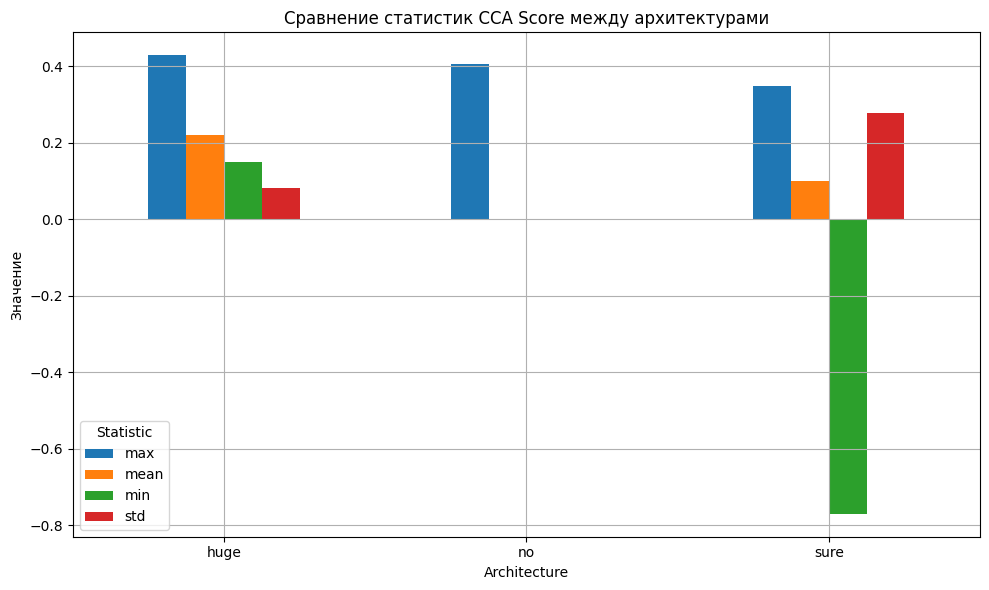

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out invalid or extreme values for better comparison
filtered_df = additional_stats_df[
    (additional_stats_df["Statistic"].isin(["mean", "std", "min", "max"]))
    & (additional_stats_df["Value"].between(-1, 1))
]

# Pivot the data for plotting
pivot_df = filtered_df.pivot(index="Statistic", columns="Architecture", values="Value")

# Plot
plt.figure(figsize=(10, 6))
pivot_df.T.plot(kind="bar", figsize=(10, 6))
plt.title("Сравнение статистик CCA Score между архитектурами")
plt.ylabel("Значение")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{results_folder}cca_score_statistics_comparison.pdf")
plt.show()

In [14]:
# Helper to extract layer statistics for weights, gradients, and Hessians from 'feature_importance'
def extract_full_layer_group_stats(data, architecture):
    groupB = data.get("aggregated_cca", {}).get("feature_importance", {}).get("groupB", {})
    results = []
    for feature, importance in groupB.items():
        if any(key in feature for key in ["weights", "gradient", "eigens"]) and importance != 1.0:
            results.append(
                {"Architecture": architecture, "Feature": feature, "Importance": importance}
            )
    return results


# Collect detailed feature stats across layers
detailed_stats = []
for arch, arch_data in data.items():
    detailed_stats.extend(extract_full_layer_group_stats(arch_data, arch))

# Convert to DataFrame
detailed_stats_df = pd.DataFrame(detailed_stats)
detailed_stats_df

,Architecture,Feature,Importance
0,no,layer_3_eigens_mean,0.133333
1,no,layer_3_weights_mean_val,0.133333
2,no,layer_3_gradient_mean_val,0.133333
3,no,layer_3_bias_gradient_mean_val,0.133333
4,sure,layer_3_eigens_mean,0.153846
5,sure,layer_3_weights_mean_val,0.153846
6,sure,layer_3_gradient_mean_val,0.153846
7,sure,layer_3_bias_gradient_mean_val,0.153846


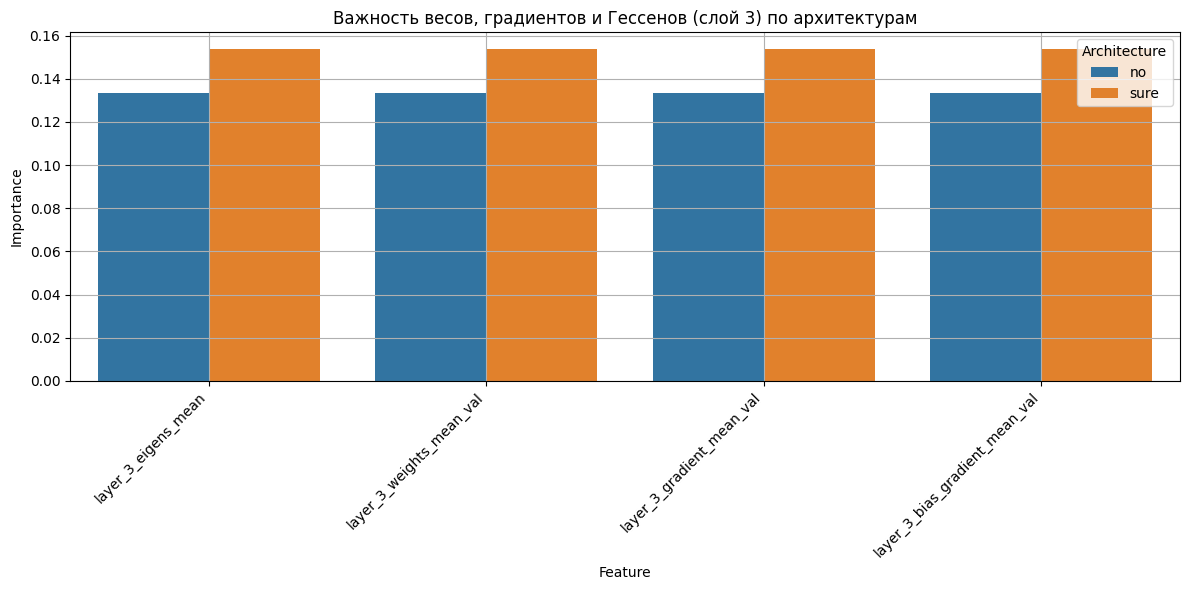

In [15]:
# Plot feature importances for weights/gradients/eigens in layer 3
plt.figure(figsize=(12, 6))
sns.barplot(data=detailed_stats_df, x="Feature", y="Importance", hue="Architecture")
plt.title("Важность весов, градиентов и Гессенов (слой 3) по архитектурам")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.tight_layout()
plt.grid(True)
plt.savefig(f"{results_folder}feature_importance_layer3.pdf")
plt.show()

In [16]:
# export all dataframes to csv files
def export_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"Exported {filename} successfully.")

In [17]:
export_to_csv(pivot_df, f"{results_folder}aggregated_cca_x_weights_by_shape.csv")
export_to_csv(pivot_y_df, f"{results_folder}aggregated_cca_y_weights_by_shape.csv")
export_to_csv(top_weight_diff_df, f"{results_folder}top_weight_differentiating_parameters.csv")
export_to_csv(stats_df, f"{results_folder}cca_statistics_by_shape.csv")
export_to_csv(additional_stats_df, f"{results_folder}additional_statistics.csv")

Exported ./handle_results/aggregated_cca_x_weights_by_shape.csv successfully.
Exported ./handle_results/aggregated_cca_y_weights_by_shape.csv successfully.
Exported ./handle_results/top_weight_differentiating_parameters.csv successfully.
Exported ./handle_results/cca_statistics_by_shape.csv successfully.
Exported ./handle_results/additional_statistics.csv successfully.


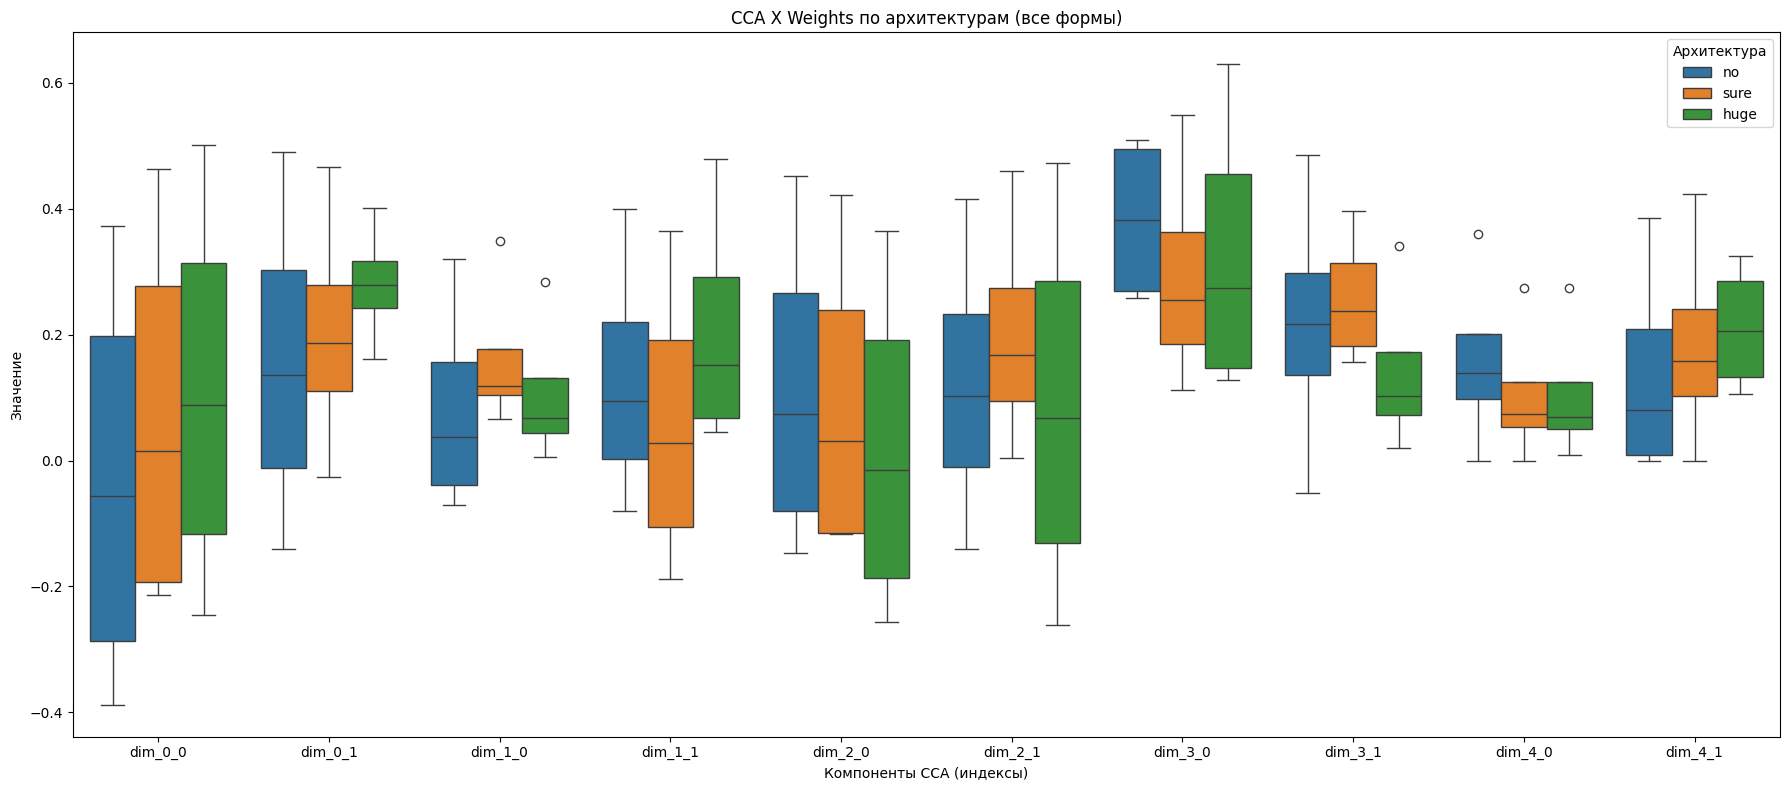

In [ ]:
# Соберем все доступные формы CCA X Weights и создадим полный DataFrame
full_cca_x_data = []

for arch, content in data.items():
    x_shapes = content.get("aggregated_cca", {}).get("aggregated_x_weights", {}).get("by_shape", {})
    for shape, stats in x_shapes.items():
        for stat in ["mean", "median", "std", "var"]:
            if stat in stats:
                matrix = stats[stat]
                for i, row in enumerate(matrix):
                    for j, val in enumerate(row):
                        full_cca_x_data.append(
                            {
                                "architecture": arch,
                                "shape": shape,
                                "statistic": stat,
                                "dim": f"dim_{i}_{j}",
                                "value": val,
                            }
                        )

full_cca_x_df = pd.DataFrame(full_cca_x_data)

# Построим boxplot для всех форм X Weights
plt.figure(figsize=(18, 8))
sns.boxplot(data=full_cca_x_df, x="dim", y="value", hue="architecture")
plt.title("CCA X Weights по архитектурам (все формы)")
plt.xlabel("Компоненты CCA (индексы)")
plt.ylabel("Значение")
plt.legend(title="Архитектура")
plt.tight_layout()
plt.savefig(f"{results_folder}cca_x_weights_all_shapes.pdf")
plt.show()

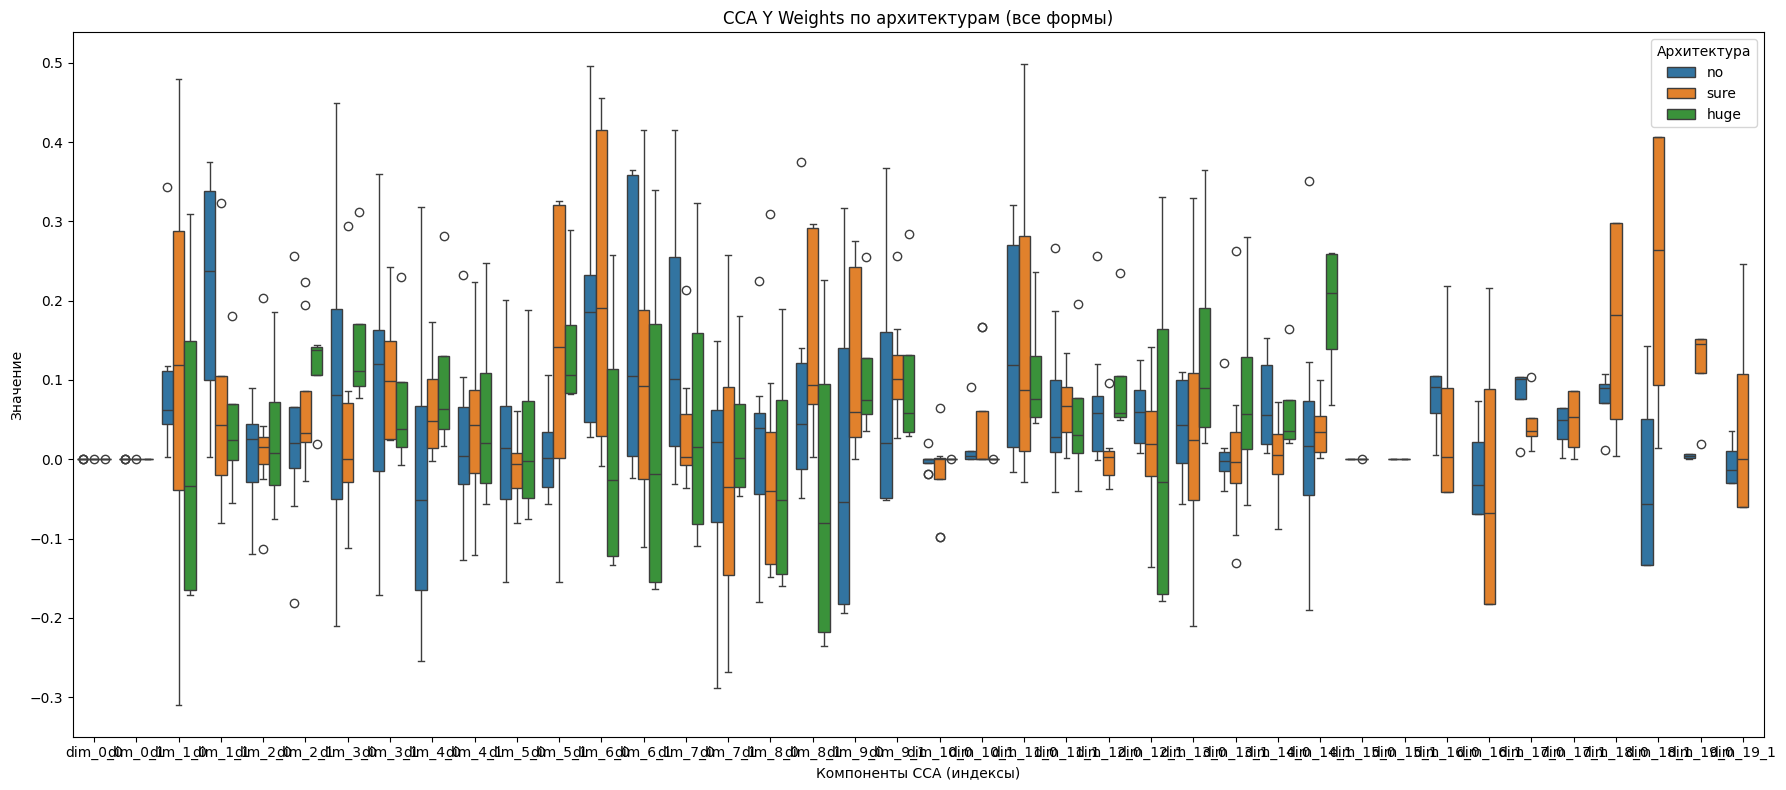

In [21]:
# Соберем все доступные формы CCA Y Weights и создадим полный DataFrame
full_cca_y_data = []

for arch, content in data.items():
    y_shapes = content.get("aggregated_cca", {}).get("aggregated_y_weights", {}).get("by_shape", {})
    for shape, stats in y_shapes.items():
        for stat in ["mean", "median", "std", "var"]:
            if stat in stats:
                matrix = stats[stat]
                for i, row in enumerate(matrix):
                    for j, val in enumerate(row):
                        full_cca_y_data.append(
                            {
                                "architecture": arch,
                                "shape": shape,
                                "statistic": stat,
                                "dim": f"dim_{i}_{j}",
                                "value": val,
                            }
                        )

full_cca_y_df = pd.DataFrame(full_cca_y_data)

# Построим boxplot для всех форм
plt.figure(figsize=(18, 8))
sns.boxplot(data=full_cca_y_df, x="dim", y="value", hue="architecture")
plt.title("CCA Y Weights по архитектурам (все формы)")
plt.xlabel("Компоненты CCA (индексы)")
plt.ylabel("Значение")
plt.legend(title="Архитектура")
plt.tight_layout()
plt.savefig(f"{results_folder}cca_y_weights_all_shapes.pdf")
plt.show()